In [200]:
#!pip install pandas_datareader

In [201]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [202]:
COMPANY = 'AAPL'

In [203]:
# how many days do i want to base my predictions on ?
prediction_days = 120

In [204]:
df = pd.read_csv(COMPANY+'.csv')
data = df.iloc[:,4:5]
data.head()

,Close
0,45.430000
1,44.992500
2,44.610001
3,44.662498
4,44.505001


In [205]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))
scaled_data

array([[0.06747461],
       [0.06448749],
       [0.06187591],
       ...,
       [0.80104121],
       [0.7854741 ],
       [0.77120426]])

In [206]:
train = int(len(scaled_data) * 0.80) #creating sizes of train and taking 80% percentage of the part
test = len(scaled_data) - train #creating sizes of test as total minus train
train,test

(1007, 252)

In [207]:
# how many days do i want to base my predictions on ?
#prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [208]:


def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model



In [209]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 120, 50)           10400     
                                                                 
 dropout_30 (Dropout)        (None, 120, 50)           0         
                                                                 
 lstm_31 (LSTM)              (None, 120, 50)           20200     
                                                                 
 dropout_31 (Dropout)        (None, 120, 50)           0         
                                                                 
 lstm_32 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_32 (Dropout)        (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 1)               

In [210]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=20, 
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/20
36/36 [==============================] - 11s 125ms/step - loss: 0.0454
Epoch 2/20
36/36 [==============================] - 4s 125ms/step - loss: 0.0066
Epoch 3/20
36/36 [==============================] - 5s 134ms/step - loss: 0.0052
Epoch 4/20
36/36 [==============================] - 5s 127ms/step - loss: 0.0051
Epoch 5/20
36/36 [==============================] - 5s 126ms/step - loss: 0.0043
Epoch 6/20
36/36 [==============================] - 4s 125ms/step - loss: 0.0043
Epoch 7/20
36/36 [==============================] - 5s 127ms/step - loss: 0.0039
Epoch 8/20
36/36 [==============================] - 5s 137ms/step - loss: 0.0036
Epoch 9/20
36/36 [==============================] - 5s 127ms/step - loss: 0.0045
Epoch 10/20
36/36 [==============================] - 5s 136ms/step - loss: 0.0040
Epoch 11/20
36/36 [==============================] - 5s 145ms/step - loss: 0.0040
Epoch 12/20
36/36 [==============================] - 6s 166ms/step - loss: 0.0038
Epoch 13/20
36/36 [=====

In [211]:
# test model accuracy on existing data
test_data = data[train:]

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [212]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

8/8 [==============================] - 2s 46ms/step


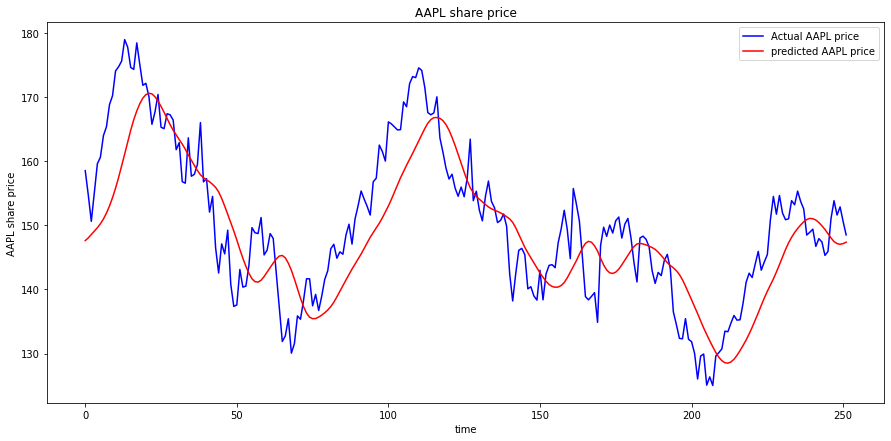

In [213]:
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(actual_prices, color='blue', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color= 'red', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [214]:
# predicting next day
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [215]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction}")

1/1 [==============================] - 1s 1s/step
prediction: [[147.6158]]


In [216]:
#data['Close'][1258]
P = data['Close'].values
print('Last price: ',P[-1])
print('Predicted price: ',prediction[0][0])

Last price:  148.5
Predicted price:  147.6158
